In [15]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
import pandas as pd
import numpy as np
import random
import os
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
import time
import networkx as nx
from sklearn.cluster import KMeans
import seaborn as sns

plt.rcParams['axes.unicode_minus']=False

path = 'result/reservoir observer'
if not os.path.exists(path):
    os.makedirs(path)
    

class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))

In [2]:
def NNMatrix(data):
    D = pairwise_distances(data,data) 
    D+= np.max(D)*10*np.eye(len(D))
    NNM = np.zeros(D.shape)
    for i in range(len(NNM)):
        NNM[i, np.argmin(D[i])] = 1
    return NNM

def MNNF(X_train, Y_train):
    def NND(data):
        D = pairwise_distances(data,data) 
        D+= np.max(D)*10*np.eye(len(D))
        return D, np.argmin(D,axis=1), np.min(D, axis=1)

    xd, xnn,xnnd = NND(X_train.T)
    yd, ynn,ynnd = NND(Y_train.T)

    MNNF = []
    for i in range(num_train):
        MNNF.append((xd[i,ynn[i]]*yd[i,xnn[i]])/(xnnd[i] * ynnd[i]))

    return np.average(np.sqrt(MNNF))

In [3]:
def black_box(a, K, inputscaling, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    X_test = X[:,test_start : test_start + num_test]
    err = Y_test - Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
    err = np.max(np.average(np.square(err), axis=1))
    return -np.log10(err)

def pairwise_distances(X, Y):
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0
    return D

def clustering(data, N_c):
    estimator = KMeans(init='random', n_clusters=N_c, n_init=3)
    estimator.fit(data)
    return estimator.cluster_centers_

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""
    def omega_approx(beta):
        """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        """Return lambda star for given beta. Equation (11) from Gavish 2014."""
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                   (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

    
from functools import partial
def partial_black_box_attn(beta):
    reg=1e-6
    S = np.exp(- 2**beta * pairwise_distances(Cs, (np.diag(Diag)@ Mr).T))
    H = np.vstack((np.ones((1,num_train)), X_train, S))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    S = np.exp( - 2**beta* pairwise_distances(Cs, (MlT @ X_test).T))
    H = np.vstack((np.ones((1,num_test)), X_test, S))
    err = np.max(np.average(np.square(Wout @ H - Y_test), axis=1))
    return -np.log10(err)

# bayesian optimization

In [67]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

for inputdata, dim in zip(
    [
#         'x',
#         'y',
#         'z', 
        'xyz'
#         'xy',
#         'yz',
#         'xz'
    ],[
#         [0],
#         [1],
#         [2],
        [0,1,2]
#         [0,1],
#         [1,2],
#         [0,2]
    ]):
    print(inputdata)
    system_name = 'Lorenz'
    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
#     U0 = np.sum(Y, axis=0, keepdims=True)
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    outSize = 3  
    resSize = 100

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[:,train_start : train_start + num_train]
    Y_test = Y[:,test_start : test_start + num_test]

    seed = 42
    random.seed(seed) 
    np.random.seed(seed)
    Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
    W0 = np.random.rand(resSize,resSize)-0.5
    largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
    rhoW = np.sqrt(largest_eigvals[0])


    # Bounded region of parameter space
    pbounds = {
        'a': (0, 1), 
        'K': (0, 3),
        'inputscaling': (0,3),
    }
    
#     bounds_transformer = SequentialDomainReductionTransformer()


    optimizer = BayesianOptimization(
        f=black_box,
        pbounds=pbounds,
        verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=seed,
#         bounds_transformer=bounds_transformer
    )
    
#     optimizer.probe(
#         params=[0.1,1.9,1.0,1e-6],
#         lazy=True,
#     )
    
    optimizer.maximize(
        init_points=30,
        n_iter=100,
        acq="ei", xi=1e-4
    )
    
    print(optimizer.max)
    params = optimizer.max['params']
    a, K, inputscaling  = params['a'], params['K'], params['inputscaling'],
#     multistep_prediction(a, K, inputscaling)

    reg = 1e-6
    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    X_test = X[:,test_start : test_start + num_test]
    Y_pred = Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
    err = Y_test - Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
    print(np.average(err, axis=1))

#     for i in range(3):
#         plt.figure()
#         plt.plot(Y_test[i])
#         plt.plot(Y_pred[i])
#         plt.show()
    
    print('MNNF: ',MNNF(X_train, Y_train))

xyz
U shape: (3, 20000)
Y shape: (3, 20000)
|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.937    |  1.796    |  0.156    |  0.468    |
|  8        |  6.948    |  0.4185   |  0.2921   |  1.099    |
|  13       |  6.955    |  0.9138   |  0.09767  |  2.053    |
|  14       |  6.968    |  1.32     |  0.122    |  1.486    |
|  31       |  7.007    |  1.625    |  0.2694   |  0.8371   |
|  39       |  7.043    |  1.532    |  0.2372   |  0.6907   |
|  58       |  7.064    |  0.8336   |  0.1339   |  1.243    |
{'target': 7.063723973280505, 'params': {'K': 0.8335658652498183, 'a': 0.13394473762197, 'inputscaling': 1.2429766624192058}}
[-2.36833226e-05 -3.13847550e-05 -9.25789028e-06]
MNNF:  1.2523412376757788


In [84]:
def plot(a, K, inputscaling, reg=1e-6):
    reg = 1e-6
    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    X_test = X[:,test_start : test_start + num_test]
    Y_pred = Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
    err = Y_test - Y_pred
    err = np.average(np.square(err), axis=1)

#     for i in range(3):
#         plt.figure(figsize=(20,3))
#         plt.plot(Y_test[i])
#         plt.plot(Y_pred[i])
#         plt.show()
    return err

def plot_attn(a, K, inputscaling, beta, reg=1e-6):
    S = np.exp(- 2**beta * pairwise_distances(Cs, (np.diag(Diag)@ Mr).T))
    H = np.vstack((np.ones((1,num_train)), X_train, S))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    S = np.exp( - 2**beta* pairwise_distances(Cs, (MlT @ X_test).T))
    H = np.vstack((np.ones((1,num_test)), X_test, S))
    Y_pred = Wout @ H
    err = Y_test - Y_pred
    err = np.average(np.square(err), axis=1)

#     for i in range(3):
#         plt.figure(figsize=(20,3))
#         plt.plot(Y_test[i])
#         plt.plot(Y_pred[i])
#         plt.show()
    return err

# 2 stage

In [89]:
for system_name in ['Lorenz','Rossler']:
    filename = path+'/{}-mfnn-kr.csv'.format(system_name)
    if os.path.exists(filename):
        os.remove(filename)

    for inputdata, dim in zip(
        [
            'x',
            'y',
            'z', 
            'xyz'
        ],[
            [0],
            [1],
            [2],
            [0,1,2]
        ]):
        print(inputdata)


        Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
        U0 = Y[dim].copy()
        if len(dim) > 1:
            U0 = np.sum(Y, axis=0, keepdims=True)
        U = U0 + np.random.randn(*U0.shape)*1e-3
        U = np.atleast_2d(U)

        num_prepare = 1000
        train_start = num_prepare
        num_train = 10000
        val_start = num_prepare + num_train
        num_val = 1000
        test_start = num_prepare + num_train + num_val
        num_test = 5000
        print('U shape:', U.shape)
        print('Y shape:', Y.shape)


        inSize = U.shape[0]
        outSize = 3  
        resSize = 100

        U_train = U[:,train_start : train_start + num_train]
        Y_train = Y[:,train_start : train_start + num_train]
        Y_test = Y[:,test_start : test_start + num_test]
        for seed in range(100):
            print(seed)
            random.seed(seed) 
            np.random.seed(seed)

            Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
            W0 = np.random.rand(resSize,resSize)-0.5
            largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
            rhoW = np.sqrt(largest_eigvals[0])


            # --------------------- stage 1 -----------------------
            eps = 1e-8
            pbounds = {
                'a': (eps, 1), 
                'K': (eps, 3),
                'inputscaling': (eps,3),
            }
            optimizer = BayesianOptimization(
                f=black_box,
                pbounds=pbounds,
                verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
                random_state=seed,
            )
            optimizer.maximize(
                init_points=30,
                n_iter=100,
                acq="ei", xi=1e-4
            )
            print(optimizer.max)

            params = optimizer.max['params']
            target1 = optimizer.max['target']
            a, K, inputscaling = params['a'], params['K'], params['inputscaling']
            err1 = plot(a, K, inputscaling)

            # -------------------------- stage 2 --------------------------
            N_c = 100
            W = W0/rhoW*K 
            Win = Win0*inputscaling
            X = np.zeros((resSize,U.shape[1]))
            x = np.zeros([resSize,1])
            for t in range(U.shape[1]):
                u = U[:,t:t+1]
                x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
                X[:,t:t+1] = x

            X_train = X[:,train_start : train_start + num_train]
            X_test = X[:,test_start : test_start + num_test]

            Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
            tau = svht(X_train, sv=Diag)
            N_v = np.sum(Diag>tau)
            MlT, Diag, Mr = Ml.T[:N_v], Diag[:N_v], Mr[:N_v]
            Cs = clustering((np.diag(Diag)@ Mr).T, N_c)  # N_c, N_v

            pbounds2 = {
                'beta': (-5,5),
            }
            bounds_transformer2 = SequentialDomainReductionTransformer()
            optimizer2 = BayesianOptimization(
                f=partial_black_box_attn,
                pbounds=pbounds2,
                verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
                random_state=seed,
                bounds_transformer=bounds_transformer2
            )
            optimizer2.maximize(
                init_points=30,
                n_iter=100,
                acq="ei", xi=1e-4
            )
            print(optimizer2.max)
            beta = optimizer2.max['params']['beta']
            target2 = optimizer2.max['target']
            err2 = plot_attn(a, K, inputscaling, beta)

            mfnn = MNNF(X_train, Y_train)
            print('MNNF: ', mfnn)

            with open(filename, 'a') as file:
                file.write('{},{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(inputdata, seed, mfnn, err1[0], err1[1],err1[2], err2[0],err2[1],err2[2], a, K, inputscaling, beta))



x
U shape: (1, 20000)
Y shape: (3, 20000)
0
|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  3.099    |  1.635    |  0.4237   |  1.938    |
|  6        |  4.434    |  0.2614   |  0.02022  |  2.498    |
|  15       |  5.7      |  2.093    |  0.06023  |  2.0      |
|  23       |  5.823    |  2.463    |  0.0971   |  2.514    |
|  28       |  6.005    |  1.243    |  0.06415  |  2.077    |
|  42       |  6.007    |  1.266    |  0.05989  |  2.057    |
|  49       |  6.041    |  2.085    |  0.09513  |  1.982    |
|  55       |  6.086    |  2.072    |  0.1011   |  1.944    |
|  63       |  6.098    |  2.107    |  0.1178   |  1.906    |
|  64       |  6.133    |  2.077    |  0.1084   |  1.868    |
|  82       |  6.147    |  2.052    |  0.1182   |  1.801    |
|  103      |  6.165    |  2.038    |  0.1194   |  1.699    |
|  104      |  6.182    |  1.986    |  0.1016   |  1.744    |
{'target': 6.1816730536677

|  38       |  6.43     | -0.8434   |
|  39       |  6.43     | -0.8368   |
|  43       |  6.43     | -0.8319   |
|  46       |  6.43     | -0.8286   |
|  61       |  6.43     | -0.828    |
|  91       |  6.43     | -0.828    |
|  95       |  6.43     | -0.828    |
|  114      |  6.43     | -0.828    |


D:\anaconda3\lib\site-packages\bayes_opt\util.py:126: RuntimeWarning: divide by zero encountered in true_divide
  z = a / std


{'target': 6.430201482417565, 'params': {'beta': -0.8280102704032734}}
MNNF:  14.171385534470962
5
|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  3.123    |  2.756    |  0.4884   |  1.835    |
|  3        |  3.279    |  2.298    |  0.5184   |  0.8904   |
|  4        |  5.321    |  0.5632   |  0.08074  |  2.215    |
|  23       |  5.776    |  1.083    |  0.03551  |  1.639    |
|  44       |  6.071    |  1.396    |  0.06606  |  2.941    |
|  62       |  6.079    |  1.107    |  0.0562   |  1.565    |
|  91       |  6.089    |  1.148    |  0.08018  |  1.632    |
|  92       |  6.139    |  1.212    |  0.07685  |  1.634    |
|  105      |  6.151    |  1.212    |  0.07371  |  1.671    |
|  119      |  6.174    |  2.139    |  0.07977  |  2.892    |
{'target': 6.173658027652446, 'params': {'K': 2.1386918470966454, 'a': 0.07977107675638812, 'inputscaling': 2.891902409441563}}
|   iter    |  target   |   b

D:\anaconda3\lib\site-packages\bayes_opt\util.py:126: RuntimeWarning: divide by zero encountered in true_divide
  z = a / std


{'target': 6.236716130813223, 'params': {'beta': 0.2723657262894911}}
MNNF:  26.55962895647356
8
|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  2.223    |  1.593    |  0.2327   |  0.0342   |
|  3        |  2.83     |  1.291    |  0.4024   |  1.568    |
|  6        |  3.019    |  1.278    |  0.2891   |  2.922    |
|  8        |  5.281    |  2.949    |  0.1279   |  0.9664   |
|  14       |  6.071    |  1.915    |  0.06869  |  1.811    |
|  35       |  6.083    |  1.928    |  0.08055  |  1.784    |
|  40       |  6.084    |  1.973    |  0.06648  |  1.795    |
|  41       |  6.122    |  1.988    |  0.08191  |  1.741    |
{'target': 6.122053005873355, 'params': {'K': 1.9875371728793625, 'a': 0.0819108877832381, 'inputscaling': 1.7414746125189338}}
|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.233    |  3.692    |
|  4        |  6.284    |  0.3086   |
|  

ValueError: LBFGSB - one of the lower bounds is greater than an upper bound.

# reconstruction result

In [13]:
plt.close('all')
plt.ion()
names = [
    'lorenz',
    'rossler',
    'rabinovich_fabrikant',
    'chua'
]

def lighter(clr, f=1/3):
    """
    An implementation of Mathematica's Lighter[] 
    function for RGB colors
    clr : 3-tuple or list, an RGB color
    f : float, the fraction by which to brighten
    """
    gaps = [f*(1 - val) for val in clr]
    new_clr = [val + gap for gap, val in zip(gaps, clr)]
    return new_clr

def plot3dproj(x, y, z, *args, color=(0,0,0), shadow_dist=1.0, color_proj=None, 
    elev_azim=(39,-47), show_labels=True, **kwargs):
    """
    Create a three dimensional plot, with projections onto the 2D coordinate
    planes
    
    Parameters
    ----------
    x, y, z : 1D arrays of coordinates to plot
    *args : arguments passed to the matplotlib plt.plot functions
    - color : length-3 tuple
        The RGB color (with each element in [0,1]) to use for the
        three dimensional line plot
    - color_proj : length-3 tuple
        The RGB color (with each element in [0,1]) to use for the
        two dimensional projection plots. Defaults to a lighter version of the 
        plotting color
    - shadow_dist : float
        The relative distance of axes to their shadow. If a single value, 
        then the same distance is used for all three axies. If a triple, then 
        different values are used for all axes
    - elev_azim : length-2 tuple
        The starting values of elevation and azimuth when viewing the figure
    - show_labels : bool
        Whether to show numerical labels on the axes
    """

    if not color_proj:
        color_proj = lighter(color, .6)


    if np.isscalar(shadow_dist) == 1:
        sdist_x = shadow_dist
        sdist_y = shadow_dist
        sdist_z = shadow_dist
    else:
        sdist_x, sdist_y, sdist_z = shadow_dist

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection= '3d')
    
    ax.plot(x, z, *args, zdir='y', zs=sdist_y*np.max(y), color=color_proj, **kwargs)
    ax.plot(y, z, *args, zdir='x', zs=sdist_x*np.min(x), color=color_proj, **kwargs)
    ax.plot(x, y, *args, zdir='z', zs=sdist_z*np.min(z), color=color_proj, **kwargs)
    ax.plot(x, y, z, *args, color=color, **kwargs)

    ax.view_init(elev=elev_azim[0], azim=elev_azim[1])
#     ax.set_aspect('auto', adjustable='box') 
    
#     ratio = 1.0
#     xvals, yvals = ax.get_xlim(), ax.get_ylim()
#     xrange = xvals[1]-xvals[0]
#     yrange = yvals[1]-yvals[0]
#     ax.set_aspect(ratio*(xrange/yrange), adjustable='box')

    if not show_labels:
        ax.set_xticklabels([])                               
        ax.set_yticklabels([])                               
        ax.set_zticklabels([])

#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z')
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

    return ax


x
U shape: (1, 20000)
Y shape: (3, 20000)
0.2067217414207582 2.2682026171128937 1.1007164084943637


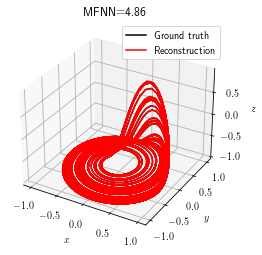

y
U shape: (1, 20000)
Y shape: (3, 20000)
0.3397757454488238 2.233957121278759 0.9956332909251396


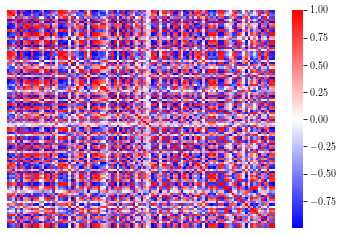

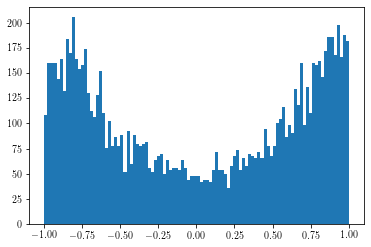

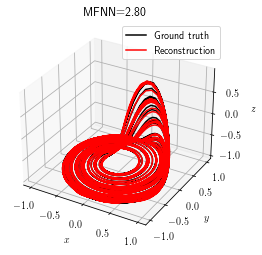

z
U shape: (1, 20000)
Y shape: (3, 20000)
0.0629446527969338 2.7669827872148174 2.885898437785738


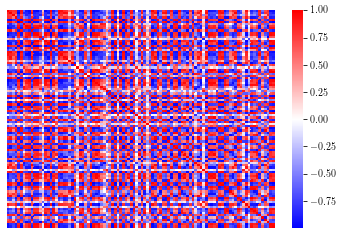

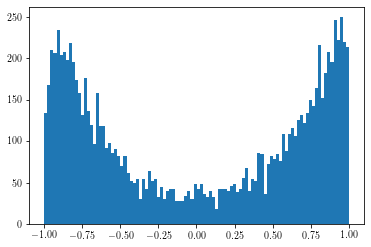

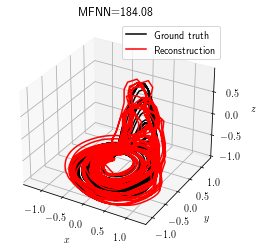

xyz
U shape: (1, 20000)
Y shape: (3, 20000)
0.1597856786971628 1.4384942344102374 1.5374383433108976


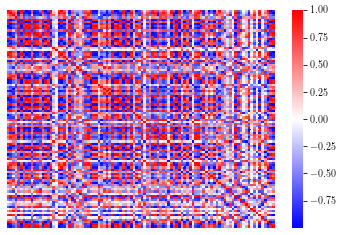

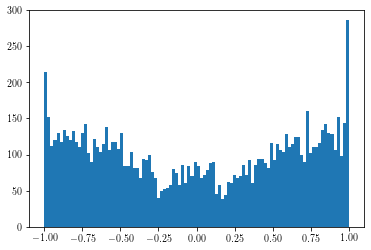

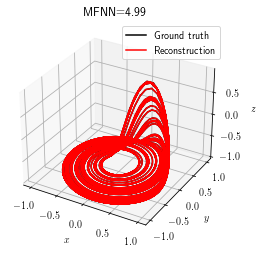

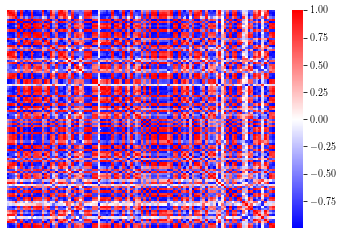

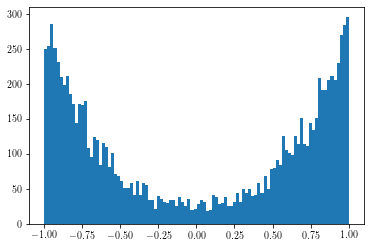

In [9]:
system_name = 'Rossler'
filename = path+'/{}-mfnn-kr.csv'.format(system_name)
df = pd.read_csv(filename, names=['inputdata', 'seed', 'mfnn','e1x', 'e1y','e1z','e2x', 'e2y','e2z',  'a', 'K', 'inputscaling','beta'])

for inputdata, dim in zip(
    [
        'x',
        'y',
        'z', 
        'xyz'
    ],[
        [0],
        [1],
        [2],
        [0,1,2]
    ]):
    print(inputdata)


    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    if len(dim) > 1:
        U0 = np.sum(Y, axis=0, keepdims=True)
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    outSize = 3  
    resSize = 100

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[:,train_start : train_start + num_train]
    Y_test = Y[:,test_start : test_start + num_test]
    
    seed = 5
    random.seed(seed) 
    np.random.seed(seed)
    Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
    W0 = np.random.rand(resSize,resSize)-0.5
    largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
    rhoW = np.sqrt(largest_eigvals[0])

    row = df.query('inputdata == \'{}\' and seed=={}'.format(inputdata, seed))
    a = row['a'].iloc[0]
    K = row['K'].iloc[0]
    mfnn = row['mfnn'].iloc[0]
    inputscaling = row['inputscaling'].iloc[0]
    print(a,K,inputscaling)


    reg = 1e-6
    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    X_test = X[:,test_start : test_start + num_test]
    Y_pred = Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
    
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    plt.plot(*Y_test, 'k', label='Ground truth')
    plt.plot(*Y_pred, 'r', label='Reconstruction')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
#     ax.set_xticks([])
    plt.title('MFNN={:.2f}'.format(mfnn))
    plt.legend()
#     plt.tight_layout()
    plt.savefig(path+'/{}-{}-reconstruction.pdf'.format(system_name,inputdata))
    plt.show()

#     Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
#     plot3dproj(Mr[0], Mr[1], Mr[3], shadow_dist=2.5, elev_azim=(20,-40), linewidth=.15, show_labels=False)
#     plt.tight_layout()
#     plt.show()

    corr = np.array(pd.DataFrame(X_train.T).corr())
    sns.heatmap(corr, xticklabels=False, yticklabels=False, cmap='bwr')
    
    plt.figure()
    plt.hist(corr.flatten(), bins=100)


In [28]:
system_name = 'Lorenz'
path = 'result/reservoir observer'
filename = path+'/{}-mfnn-kr.csv'.format(system_name)
df0 = pd.read_csv(filename, names=['inputdata', 'seed', 'mfnn','e1x', 'e1y','e1z','e2x', 'e2y','e2z',  'a', 'K', 'inputscaling','beta'])
df0

,inputdata,seed,mfnn,e1x,e1y,e1z,e2x,e2y,e2z,a,K,inputscaling,beta
0,x,0,16.198086,1.704622e-07,6.273397e-07,7.811298e-07,1.334659e-07,3.495597e-07,4.170553e-07,0.117633,2.031571,1.850332,-0.978426
1,x,1,21.209496,1.949464e-07,7.949127e-07,4.907740e-07,1.515228e-07,5.156720e-07,4.373507e-07,0.062019,1.457536,1.746571,-3.633620
2,x,2,24.700778,1.853323e-07,8.775297e-07,7.537218e-07,1.494018e-07,5.164041e-07,4.889804e-07,0.075936,1.597342,1.913708,-0.172383
3,x,3,20.810148,1.698621e-07,6.751834e-07,5.319211e-07,1.515356e-07,4.701463e-07,3.789724e-07,0.092073,1.695563,1.505842,-1.030137
4,x,4,19.177397,1.463496e-07,5.163554e-07,4.177580e-07,1.343476e-07,3.942311e-07,3.298946e-07,0.069978,1.622313,1.652510,-0.322205
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,xyz,15,33.803728,2.594176e-05,1.654864e-05,1.157719e-04,7.612053e-06,5.022335e-06,2.711635e-05,0.044296,1.090665,2.104192,-2.233060
127,xyz,16,34.858010,2.585863e-05,1.871550e-05,1.052586e-04,6.088523e-06,4.770446e-06,1.785140e-05,0.052470,1.171737,1.585559,-1.826808
128,xyz,17,82.259816,1.987664e-05,1.422886e-05,1.022685e-04,1.079368e-05,7.029682e-06,5.680763e-05,0.040977,0.553845,1.085620,-1.644703
129,xyz,18,32.025699,1.811325e-05,1.309062e-05,5.500434e-05,9.030614e-06,6.474745e-06,2.844525e-05,0.073882,1.200454,0.582835,-1.310944


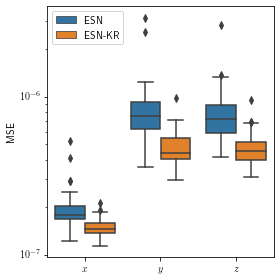

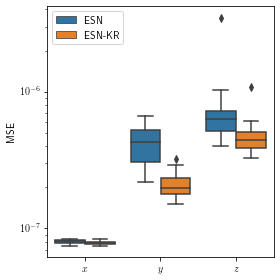

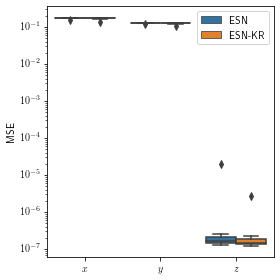

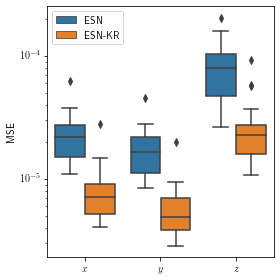

In [29]:
for dim in ['x','y','z','xyz']:
    df = df0[df0['inputdata'] == dim]

    indice1 = ['e1x', 'e1y','e1z']
    indice2 = ['e2x', 'e2y','e2z']
    indice_new = ['x','y','z']

    temp = pd.concat([pd.DataFrame(df[indice1].values, columns=indice_new),pd.DataFrame(df[indice2].values, columns=indice_new)],
              keys=('ESN','ESN-KR'))\
    .stack()\
    .rename_axis(index=['Model', '', 'Dim'])\
    .reset_index(level=[0,2], name='MSE')

    plt.figure(figsize=(4,4))
    ax = sns.boxplot(data=temp, x='Dim', hue='Model', y='MSE')
    handles,labels = ax.get_legend_handles_labels()          # Get the artists.
    ax.legend(handles, labels, loc="best")
    ax.set_xticklabels([r'$x$', r'$y$', r'$z$'])
    plt.yscale('log')
    plt.xlabel('')
    plt.ylabel('MSE')
    plt.tight_layout()
    plt.savefig(path+'/ESNKR-{}-{}.pdf'.format(system_name, dim))

In [30]:
for dim in ['x','y','z','xyz']:
    df = df0[df0['inputdata'] == dim]
    de = df.describe()
    for d in ['x','y','z']:
        print((de['e1'+d]['mean'] - de['e2'+d]['mean'])/de['e1'+d]['mean']*100)
    print()

23.28230160209656
42.768281037732365
39.8597598204779

1.5841619578134514
49.023361098260125
38.028272263371264

0.7875084944297256
0.6381395640738198
76.22431720354467

64.44952244135726
65.73144733273094
66.14214322354258



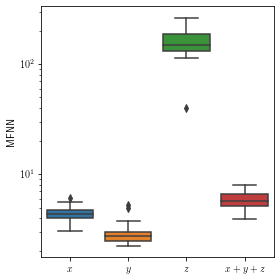

In [8]:
plt.figure(figsize=(4,4))
g = sns.boxplot(data=df0, x='inputdata', y='mfnn')
g.set_xticklabels([r'$x$', r'$y$', r'$z$', r'$x+y+z$'], rotation=0) 
plt.yscale('log')
plt.xlabel('')
plt.ylabel('MFNN')
plt.tight_layout()
plt.savefig(path+'/MFNN-{}.pdf'.format(system_name))